<a href="https://colab.research.google.com/github/chandrashekarswamy/EVA-Phase-01/blob/master/Assignment%2007/Assignment%2007%20B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

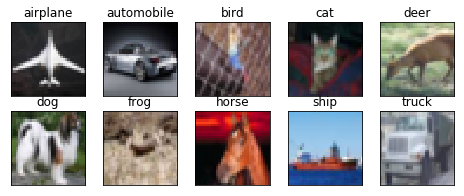

In [49]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [53]:
from keras.layers import concatenate, Input, SeparableConv2D, Add, Lambda
from keras.models import Model

# the function to implement the orgnization layer
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)

inputs = Input(shape=(32,32,3)) # 32*32*3

#First Specially Seperable Conv = SSC1
SSC1 = SeparableConv2D(64, (5, 5), border_mode='same')(inputs)  #Kernel = 5*5 channels = 64
SSC1 = Activation('relu')(SSC1)
SSC1 = BatchNormalization(axis=-1)(SSC1)
SSC1E = Dropout(0.1)(SSC1)

#First Normal Conv = NC1
NC1 = Convolution2D(64, (5, 5), border_mode='same')(SSC1E) #Kernel = 5*5 channels = 64
NC1 =  Activation('relu')(NC1)
NC1 = BatchNormalization(axis=-1)(NC1)
NC1E = Dropout(0.1)(NC1)

#Second Normal Conv = NC2
NC2 = Convolution2D(64, (5, 5), border_mode='same')(NC1E) #Kernel = 5*5 channels = 64
NC2 =  Activation('relu')(NC2)
NC2 = BatchNormalization(axis=-1)(NC2)
NC2E = Dropout(0.1)(NC2)

#skip connections
NC2EX = Add()([NC2E, SSC1E])

#Second Specially Seperable Conv = SSC2
SSC2 = SeparableConv2D(128, (5, 5), border_mode='same')(NC2EX)  #Kernel = 5*5 channels = 128
SSC2 = Activation('relu')(SSC2)
SSC2 = BatchNormalization(axis=-1)(SSC2)
SSC2E = Dropout(0.1)(SSC2)

#skip connections
SSC2EX = concatenate([SSC2E, SSC1E])

#First MaxPooline layer = MPL1 
MPL1 = MaxPooling2D((2,2))(SSC2EX)
MPL1E = Convolution2D(32, (1, 1), activation='relu')(MPL1)

#Third Specially Seperable Conv = SSC3
SSC3 = SeparableConv2D(32, (3, 3), border_mode='same')(MPL1E)  #Kernel = 3*3 channels = 64
SSC3 = Activation('relu')(SSC3)
SSC3 = BatchNormalization(axis=-1)(SSC3)
SSC3E = Dropout(0.1)(SSC3)

#Converting the SSC1E and SSC2E space to depth using lambda expression
SSC1EX = Lambda(space_to_depth_x2)(SSC1E)
SSC2EX = Lambda(space_to_depth_x2)(SSC2E)

#skip connections
SSC3EX = concatenate([SSC3E, SSC1EX, SSC2EX])

#Third Normal Conv = NC3
NC3 = Convolution2D(64, (5, 5), border_mode='same')(SSC3EX) #Kernel = 5*5 channels = 64
NC3 =  Activation('relu')(NC3)
NC3 = BatchNormalization(axis=-1)(NC3)
NC3E = Dropout(0.1)(NC3)

NC3EX = Lambda(space_to_depth_x2)(NC3E)
SSC3EX = Lambda(space_to_depth_x2)(SSC3E)
SSC2EX = Lambda(space_to_depth_x2)(SSC2E)
NC2EX = Lambda(space_to_depth_x2)(SSC2E)

#skip connections
NC3EX = concatenate([NC3E, SSC3E,SSC2EX,SSC2EX])

#Fourth Specially Seperable Conv = SSC4
SSC4 = SeparableConv2D(64, (3, 3), border_mode='same')(NC3EX)  #Kernel = 3*3 channels = 64
SSC4 = Activation('relu')(SSC4)
SSC4 = BatchNormalization(axis=-1)(SSC4)
SSC4E = Dropout(0.1)(SSC4)

#skip connections
SSC1EX = Lambda(space_to_depth_x2)(SSC1E)
NC2EX = Lambda(space_to_depth_x2)(NC2E)
SSC2EX = Lambda(space_to_depth_x2)(SSC2E)

SSC4EX =  concatenate([SSC4E,SSC1EX,NC2EX,SSC2EX,SSC3E,NC3E])

#Fifth Specially Seperable Conv = SSC5
SSC5 = SeparableConv2D(128, (5, 5), border_mode='same')(SSC4EX)  #Kernel = 5*5 channels = 128
SSC5 = Activation('relu')(SSC5)
SSC5 = BatchNormalization(axis=-1)(SSC5)
SSC5E = Dropout(0.1)(SSC5)

#4skip connections
SSC1EX = Lambda(space_to_depth_x2)(SSC1E)
SSC2EX = Lambda(space_to_depth_x2)(SSC2E)

SSC5EX =  concatenate([SSC5E, SSC3E, SSC4E, SSC1EX, SSC2EX])

#Second MaxPooline layer = MPL2 
MPL2 = MaxPooling2D((2,2))(SSC5EX)
MPL2E = Convolution2D(32, (1, 1), activation='relu')(MPL2)

NC3EX = Lambda(space_to_depth_x2)(NC3E)
#skip connections
MPL2EX =  concatenate([MPL2E, NC3EX])

#Fourth Normal Conv = NC4
NC4 = Convolution2D(32, (5, 5), border_mode='same')(MPL2EX) #Kernel = 5*5 channels = 64
NC4 =  Activation('relu')(NC4)
NC4 = BatchNormalization(axis=-1)(NC4)
NC4E = Dropout(0.1)(NC4)

SSC4EX = Lambda(space_to_depth_x2)(SSC4E)
SSC1EX = Lambda(space_to_depth_x4)(SSC1E)
NC1EX = Lambda(space_to_depth_x4)(NC1E)
#skip connections
NC4EX =  concatenate([NC4E, SSC1EX, NC1EX, SSC4EX])

#Sixth Specially Seperable Conv = SSC6
SSC6 = SeparableConv2D(64, (5, 5), border_mode='same')(NC4EX)  #Kernel = 5*5 channels = 128
SSC6 = Activation('relu')(SSC6)
SSC6 = BatchNormalization(axis=-1)(SSC6)
SSC6E = Dropout(0.1)(SSC6)

NC2EX = Lambda(space_to_depth_x4)(NC2E)
#skip connections
SSC6EX =  concatenate([SSC6E, NC1EX, NC2EX, SSC3EX, NC4E])

#Fifth Normal Conv = NC5
NC5 = Convolution2D(64, (3, 3), border_mode='same')(SSC6EX) #Kernel = 3*3 channels = 64
NC5 =  Activation('relu')(NC5)
NC5 = BatchNormalization(axis=-1)(NC5)
NC5E = Dropout(0.1)(NC5)

SSC2EX = Lambda(space_to_depth_x4)(SSC2E)
#skip connections
NC5EX =  concatenate([NC5E, NC1EX, NC2EX, SSC2EX, SSC3EX, SSC4EX, SSC6E])

#sevent Specially Seperable Conv = SSC7
SSC7 = SeparableConv2D(128, (5, 5), border_mode='same')(NC5EX)  #Kernel = 5*5 channels = 128
SSC7 = Activation('relu')(SSC7)
SSC7 = BatchNormalization(axis=-1)(SSC7)
SSC7E = Dropout(0.1)(SSC7)

#skip connections
SSC7EX =  concatenate([SSC7E, SSC2EX, SSC4EX, SSC6E])

#Softmax
S_MAX = Convolution2D(32, (8,8), activation='relu')(SSC7E)
S_MAX = Convolution2D(10, (1,1), activation='softmax')(S_MAX)
output = Flatten()(S_MAX)

model = Model(inputs=inputs, outputs=output)
model.summary()

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(64, (5, 5), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (5, 5), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_103 (Separable (None, 32, 32, 64)   331         input_22[0][0]                   
__________________________________________________________________________________________________
activation_179 (Activation)     (None, 32, 32, 64)   0           separable_conv2d_103[0][0]       
__________________________________________________________________________________________________
batch_normalization_179 (BatchN (None, 32, 32, 64)   256         activation_179[0][0]             
__________________________________________________________________________________________________
dropout_18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=195, epochs=10)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10
195/195 [==============================] - 109s 558ms/step - loss: 1.4908 - acc: 0.4718 - val_loss: 1.3786 - val_acc: 0.5292
Epoch 2/10
195/195 [==============================] - 102s 522ms/step - loss: 1.0113 - acc: 0.6448 - val_loss: 1.1120 - val_acc: 0.6280
Epoch 3/10
195/195 [==============================] - 102s 521ms/step - loss: 0.7548 - acc: 0.7365 - val_loss: 1.0428 - val_acc: 0.6735
Epoch 4/10
195/195 [==============================] - 101s 520ms/step - loss: 0.5736 - acc: 0.8002 - val_loss: 0.8192 - val_acc: 0.7306
Epoch 5/10
195/195 [==============================] - 102s 522ms/step - loss: 0.4181 - acc: 0.8548 - val_loss: 0.8880 - val_acc: 0.7292
Epoch 6/10
195/195 [==============================] - 101s 520ms/step - loss: 0.3056 - acc: 0.8960 - val_loss: 0.8906 - val_acc: 0.7470
Epoch 7/10
195/195 [==============================] - 101s 520ms/step - loss: 0.2224 - acc: 0.9225 - val_loss: 0.9518 - val_acc: 0.7427
Epoch 8/10
195/195 [============================

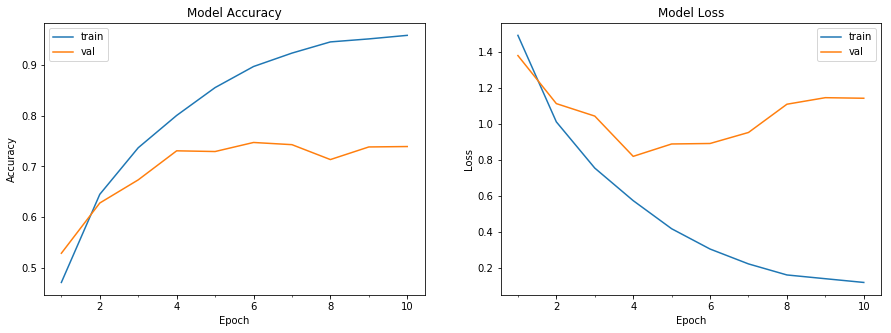

Accuracy on test data is: 73.90


In [54]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))